In [1]:
import numpy as np
import pandas as pd
finaldataset = pd.read_csv(r"D:\AliFarrokhi\Santa_Agueda\Turbidity_nocloud.csv")

finaldataset["Date"] = pd.to_datetime(finaldataset["Date"],format= "%Y-%m-%d")
finaldataset["ROI"] = 1
#finaldataset = pd.DataFrame(finaldataset[["Date","ROI","Turbidity"]])
finaldataset

,Date,Turbidity,ROI
0,2017-01-01,8.85,1
1,2017-01-01,7.91,1
2,2017-01-01,7.66,1
3,2017-01-01,8.00,1
4,2017-01-06,8.99,1
...,...,...,...
5077,2022-03-07,5.77,1
5078,2022-03-07,4.89,1
5079,2022-03-30,5.71,1
5080,2022-03-30,5.04,1


In [2]:
finaldataset = finaldataset.groupby("Date").agg({"Turbidity" : "mean", "ROI" : "first"}).reset_index()    

In [3]:
finaldataset

,Date,Turbidity,ROI
0,2017-01-01,8.105000,1
1,2017-01-06,8.328000,1
2,2017-01-07,8.452500,1
3,2017-01-11,7.767500,1
4,2017-01-14,7.778000,1
...,...,...,...
1068,2022-03-04,4.743333,1
1069,2022-03-05,4.923333,1
1070,2022-03-06,4.666667,1
1071,2022-03-07,5.006667,1


In [4]:
finaldataset.to_csv(r"D:\AliFarrokhi\Santa_Agueda\Dailyturbid.csv", index=False)

In [4]:
import ee
ee.Authenticate()

Enter verification code:  4/1AcvDMrDwpBqPpwlxcSsTPonxoias62FW6gVc6-4fpFHk-898QdzkMCnQlnk



Successfully saved authorization token.


<span style="font-size: 18px;">pixel itself</span>

In [7]:

import pandas as pd
import os
import rasterio
from rasterio.crs import CRS
import pyproj
from pyproj import transform,Proj
from pyproj import CRS, Transformer

import ee
from tqdm import tqdm

ee.Initialize()

#Cheking clouds,
roi_dict = {1: [-7.482719, 39.971727],}

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl1sen2"

band_names = ['SCL']

for index, row in tqdm(finaldataset.iterrows(),total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]
   
    roi_geometry = roi_dict.get(roi_number)
    
    if roi_geometry:
        folder_date = pd.to_datetime(date,format="%Y-%m-%d").strftime("%Y%m%d")
        l2a_folder = None
        
        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                   #print("date_parts",date_parts)
                    if date_parts ==folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break
                
        if l2a_folder:
            l2a_path = os.path.join(data_folder,l2a_folder)
            jp2_files_folder = os.path.join(l2a_path,"GRANULE")
            
            for band_name in band_names:
                jp2_file = None
                for root, _, files in os.walk(jp2_files_folder):
                    for file in files:
                        if file.endswith(f"_{band_name}_20m.jp2"):
                            jp2_file = os.path.join(root,file)
                            break
                    if jp2_file:
                        break
                        
                if jp2_file:
                    with rasterio.open(jp2_file) as src:
                        jp2_crs = src.crs
                        
                        wgs84 = CRS.from_epsg(4326)
                        transformer = Transformer.from_crs(wgs84, jp2_crs, always_xy=True)
                        lon, lat = transformer.transform(roi_geometry[0], roi_geometry[1])
                        
                        valuesC = list(src.sample([(lon, lat)]))
                        
                       
                        values = [valuesC[0][0]]
                        if any(value in [0, 1, 2, 3, 7, 8, 9, 10] for value in values):
                            SCL_status = None
                        else:
                            SCL_status = 1
                            
                        # Update the DataFrame with the pixel value
                        finaldataset.at[index, band_name] = SCL_status
                else:
                    continue
                    #print(f"JP2 file not found for {date} and band {band_name}")
        else:
            continue
            #print(f"L2A folder not found for {date}")
    else:
        continue
       # print(f"Invalid ROI number: {roi_number}")


finaldataset.dropna(subset="SCL",inplace=True)
   
print("Done!")
                        
                

100%|██████████████████████████████████████████████████████████████████████████████| 1073/1073 [07:23<00:00,  2.42it/s]

Done!


In [ ]:

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl1sen2"

band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']


for index, row in tqdm(finaldataset.iterrows(),total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]
   
    roi_geometry = roi_dict.get(roi_number)
    
    if roi_geometry:
        folder_date = pd.to_datetime(date,format="%Y-%m-%d").strftime("%Y%m%d")
       #print("folder date is",folder_date)
        #finding the folder
        l2a_folder = None
        
        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                   #print("date_parts",date_parts)
                    if date_parts ==folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break
                
        if l2a_folder:
            l2a_path = os.path.join(data_folder,l2a_folder)
            jp2_files_folder = os.path.join(l2a_path,"GRANULE")
            
            for band_name in band_names:
                jp2_file = None
                for root, _, files in os.walk(jp2_files_folder):
                    for file in files:
                        if file.endswith(f"_{band_name}_20m.jp2"):
                            jp2_file = os.path.join(root,file)
                            break
                    if jp2_file:
                        break
                        
                if jp2_file:
                    with rasterio.open(jp2_file) as src:
                        jp2_crs = src.crs
                  #     wgs84 = CRS.from_epsg(4326)
                     #  lon, lat = transform(Proj(init='epsg:4326'),Proj(jp2_crs),roi_geometry.coordinates().getInfo()[0],roi_geometry.coordinates().getInfo()[1])
                        
                        
                        wgs84 = CRS.from_epsg(4326)
                        transformer = Transformer.from_crs(wgs84, jp2_crs, always_xy=True)
                        lon, lat = transformer.transform(roi_geometry[0], roi_geometry[1])
                                      
                        valuesC = list(src.sample([(lon, lat)]))
      
                        
                        average_value = (valuesC[0][0] * 0.0001)
                           
                        # Update the DataFrame with the pixel value
                        finaldataset.at[index, band_name] = round(average_value, 6)
                else:
                    print(f"JP2 file not found for {date} and band {band_name}")
        else:
            print(f"L2A folder not found for {date}")
    else:
        print(f"Invalid ROI number: {roi_number}")


print("DataFrame updated with band values and saved successfully!")
                        
                

In [ ]:
import pandas as pd
import os
import rasterio
from rasterio.enums import Resampling
from pyproj import Transformer
from tqdm import tqdm

import ee
ee.Initialize()

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl1sen2"

band_names = ['B01']

# Define the target resolution
target_resolution = 20

for index, row in tqdm(finaldataset.iterrows(), total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]
   
    roi_geometry = roi_dict.get(roi_number)
    
    if roi_geometry:
        folder_date = pd.to_datetime(date, format="%Y-%m-%d").strftime("%Y%m%d")
        #print("folder date is",folder_date)
        #finding the folder
        l2a_folder = None
        
        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                    #print("date_parts",date_parts)
                    if date_parts == folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break
                
        if l2a_folder:
            l2a_path = os.path.join(data_folder, l2a_folder)
            jp2_files_folder = os.path.join(l2a_path, "GRANULE")
            
            for band_name in band_names:
                jp2_file = None
                for root, _, files in os.walk(jp2_files_folder):
                    for file in files:
                        if file.endswith(f"_{band_name}_60m.jp2"):
                            jp2_file = os.path.join(root, file)
                            break
                    if jp2_file:
                        break
                        
                if jp2_file:
                    with rasterio.open(jp2_file) as src:
                        # Resample data to target resolution
                        scale_factor = src.res[0] / target_resolution
                        new_height = int(src.height * scale_factor)
                        new_width = int(src.width * scale_factor)
                        
                        data = src.read(
                            out_shape=(src.count, new_height, new_width),
                            resampling=Resampling.bilinear
                        )
                        
                        # Scale image transform to the new dimensions
                        transform = src.transform * src.transform.scale(
                            (src.width / data.shape[-1]),
                            (src.height / data.shape[-2])
                        )

                        wgs84 = CRS.from_epsg(4326)
                        transformer = Transformer.from_crs(wgs84, jp2_crs, always_xy=True)
                        lon, lat = transformer.transform(roi_geometry[0], roi_geometry[1])

                        valuesC = list(src.sample([(lon, lat)]))
        
      
                        
                        average_value = (valuesC[0][0] * 0.0001)
                           
                        # Update the DataFrame with the pixel value
                        finaldataset.at[index, band_name] = round(average_value, 6)
                else:
                    print(f"JP2 file not found for {date} and band {band_name}")
        else:
            print(f"L2A folder not found for {date}")
    else:
        print(f"Invalid ROI number: {roi_number}")

print("DataFrame updated with band values and saved successfully!")


<span style="font-size: 18px;"> 9*9 pixel and average of around</span>

In [4]:
#pixel and average of around
import pandas as pd
import os
import rasterio
from rasterio.crs import CRS
import pyproj
from pyproj import transform,Proj
from pyproj import CRS, Transformer

import ee
from tqdm import tqdm

ee.Initialize()

#Cheking clouds,
roi_dict = {1: [-7.482719, 39.971727],}

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl2sen2"

band_names = ['SCL']

for index, row in tqdm(finaldataset.iterrows(),total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]
   
    roi_geometry = roi_dict.get(roi_number)
    
    if roi_geometry:
        folder_date = pd.to_datetime(date,format="%Y-%m-%d").strftime("%Y%m%d")
        l2a_folder = None
        
        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                   #print("date_parts",date_parts)
                    if date_parts ==folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break
                
        if l2a_folder:
            l2a_path = os.path.join(data_folder,l2a_folder)
            jp2_files_folder = os.path.join(l2a_path,"GRANULE")
            
            for band_name in band_names:
                jp2_file = None
                for root, _, files in os.walk(jp2_files_folder):
                    for file in files:
                        if file.endswith(f"_{band_name}_20m.jp2"):
                            jp2_file = os.path.join(root,file)
                            break
                    if jp2_file:
                        break
                        
                if jp2_file:
                    with rasterio.open(jp2_file) as src:
                        jp2_crs = src.crs
                        
                        wgs84 = CRS.from_epsg(4326)
                        transformer = Transformer.from_crs(wgs84, jp2_crs, always_xy=True)
                        lon, lat = transformer.transform(roi_geometry[0], roi_geometry[1])
                                              
                        valuesUL = list(src.sample([(lon-20, lat+20)]))
                        valuesU = list(src.sample([(lon, lat+20)]))
                        valuesUR = list(src.sample([(lon+20, lat+20)]))
                        valuesL = list(src.sample([(lon-20, lat)]))
                        valuesC = list(src.sample([(lon, lat)]))
                        valuesR = list(src.sample([(lon+20, lat)]))
                        valuesDL = list(src.sample([(lon-20, lat-20)]))
                        valuesD = list(src.sample([(lon, lat-20)]))
                        valuesDR = list(src.sample([(lon+20, lat-20)]))
                        
                       
                        values = [valuesUL[0][0], valuesU[0][0], valuesUR[0][0], valuesL[0][0], valuesC[0][0], valuesR[0][0], valuesDL[0][0], valuesD[0][0], valuesDR[0][0]]
                        if any(value in [0, 1, 2, 3, 7, 8, 9, 10] for value in values):
                            SCL_status = None
                        else:
                            SCL_status = 1
                            
                        # Update the DataFrame with the pixel value
                        finaldataset.at[index, band_name] = SCL_status
                else:
                    continue
                    #print(f"JP2 file not found for {date} and band {band_name}")
        else:
            continue
            #print(f"L2A folder not found for {date}")
    else:
        continue
       # print(f"Invalid ROI number: {roi_number}")



finaldataset.dropna(subset="SCL",inplace=True)
                        
                

100%|██████████████████████████████████████████████████████████████████████████████| 1073/1073 [06:27<00:00,  2.77it/s]


In [5]:

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl2sen2"

band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']


for index, row in tqdm(finaldataset.iterrows(),total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]
   
    roi_geometry = roi_dict.get(roi_number)
    
    if roi_geometry:
        folder_date = pd.to_datetime(date,format="%Y-%m-%d").strftime("%Y%m%d")
       #print("folder date is",folder_date)
        #finding the folder
        l2a_folder = None
        
        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                   #print("date_parts",date_parts)
                    if date_parts ==folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break
                
        if l2a_folder:
            l2a_path = os.path.join(data_folder,l2a_folder)
            jp2_files_folder = os.path.join(l2a_path,"GRANULE")
            
            for band_name in band_names:
                jp2_file = None
                for root, _, files in os.walk(jp2_files_folder):
                    for file in files:
                        if file.endswith(f"_{band_name}_20m.jp2"):
                            jp2_file = os.path.join(root,file)
                            break
                    if jp2_file:
                        break
                        
                if jp2_file:
                    with rasterio.open(jp2_file) as src:
                        jp2_crs = src.crs
                  #     wgs84 = CRS.from_epsg(4326)
                     #  lon, lat = transform(Proj(init='epsg:4326'),Proj(jp2_crs),roi_geometry.coordinates().getInfo()[0],roi_geometry.coordinates().getInfo()[1])
                        
                        
                        wgs84 = CRS.from_epsg(4326)
                        transformer = Transformer.from_crs(wgs84, jp2_crs, always_xy=True)
                        lon, lat = transformer.transform(roi_geometry[0], roi_geometry[1])
                                      
                        valuesUL = list(src.sample([(lon-20, lat+20)]))
                        valuesU = list(src.sample([(lon, lat+20)]))
                        valuesUR = list(src.sample([(lon+20, lat+20)]))
                        valuesL = list(src.sample([(lon-20, lat)]))
                        valuesC = list(src.sample([(lon, lat)]))
                        valuesR = list(src.sample([(lon+20, lat)]))
                        valuesDL = list(src.sample([(lon-20, lat-20)]))
                        valuesD = list(src.sample([(lon, lat-20)]))
                        valuesDR = list(src.sample([(lon+20, lat-20)]))
                  #     print("ValuesUL", valuesUL)
                  #     print("ValuesU", valuesU)
                  #     print("ValuesUR", valuesUR)
                  #     print("ValuesL", valuesL)
                   #    print("ValuesC", valuesC)
                    #   print("ValuesR", valuesR)
                     #  print("ValuesDL", valuesDL)
                      # print("ValuesD", valuesD)
                       #print("ValuesDR", valuesDR)
      
                        
                        average_value = (sum([valuesUL[0][0], valuesU[0][0], valuesUR[0][0], valuesL[0][0], valuesC[0][0], valuesR[0][0], valuesDL[0][0], valuesD[0][0], valuesDR[0][0]]) * 0.0001) / 9
                           
                        # Update the DataFrame with the pixel value
                        finaldataset.at[index, band_name] = round(average_value, 6)
                else:
                    print(f"JP2 file not found for {date} and band {band_name}")
        else:
            print(f"L2A folder not found for {date}")
    else:
        print(f"Invalid ROI number: {roi_number}")


print("DataFrame updated with band values and saved successfully!")
                        
                

100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:35<00:00,  3.60it/s]

DataFrame updated with band values and saved successfully!


In [9]:
import pandas as pd
import os
import rasterio
from rasterio.enums import Resampling
from pyproj import Transformer
from tqdm import tqdm

import ee
ee.Initialize()
#Cheking clouds,
roi_dict = {1: [-7.482719, 39.971727],}

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl2sen2"

band_names = ['B01']

# Define the target resolution
target_resolution = 20

for index, row in tqdm(finaldataset.iterrows(), total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]
   
    roi_geometry = roi_dict.get(roi_number)
    
    if roi_geometry:
        folder_date = pd.to_datetime(date, format="%Y-%m-%d").strftime("%Y%m%d")
        #print("folder date is",folder_date)
        #finding the folder
        l2a_folder = None
        
        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                    #print("date_parts",date_parts)
                    if date_parts == folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break
                
        if l2a_folder:
            l2a_path = os.path.join(data_folder, l2a_folder)
            jp2_files_folder = os.path.join(l2a_path, "GRANULE")
            
            for band_name in band_names:
                jp2_file = None
                for root, _, files in os.walk(jp2_files_folder):
                    for file in files:
                        if file.endswith(f"_{band_name}_60m.jp2"):
                            jp2_file = os.path.join(root, file)
                            break
                    if jp2_file:
                        break
                        
                if jp2_file:
                    with rasterio.open(jp2_file) as src:
                        # Resample data to target resolution
                        scale_factor = src.res[0] / target_resolution
                        new_height = int(src.height * scale_factor)
                        new_width = int(src.width * scale_factor)
                        
                        data = src.read(
                            out_shape=(src.count, new_height, new_width),
                            resampling=Resampling.bilinear
                        )
                        
                        # Scale image transform to the new dimensions
                        transform = src.transform * src.transform.scale(
                            (src.width / data.shape[-1]),
                            (src.height / data.shape[-2])
                        )

                        wgs84 = CRS.from_epsg(4326)
                        transformer = Transformer.from_crs(wgs84, jp2_crs, always_xy=True)
                        lon, lat = transformer.transform(roi_geometry[0], roi_geometry[1])
                                      
                        valuesUL = list(src.sample([(lon-20, lat+20)]))
                        valuesU = list(src.sample([(lon, lat+20)]))
                        valuesUR = list(src.sample([(lon+20, lat+20)]))
                        valuesL = list(src.sample([(lon-20, lat)]))
                        valuesC = list(src.sample([(lon, lat)]))
                        valuesR = list(src.sample([(lon+20, lat)]))
                        valuesDL = list(src.sample([(lon-20, lat-20)]))
                        valuesD = list(src.sample([(lon, lat-20)]))
                        valuesDR = list(src.sample([(lon+20, lat-20)]))
                  #     print("ValuesUL", valuesUL)
                  #     print("ValuesU", valuesU)
                  #     print("ValuesUR", valuesUR)
                  #     print("ValuesL", valuesL)
                   #    print("ValuesC", valuesC)
                    #   print("ValuesR", valuesR)
                     #  print("ValuesDL", valuesDL)
                      # print("ValuesD", valuesD)
                       #print("ValuesDR", valuesDR)
      
                        
                        average_value = (sum([valuesUL[0][0], valuesU[0][0], valuesUR[0][0], valuesL[0][0], valuesC[0][0], valuesR[0][0], valuesDL[0][0], valuesD[0][0], valuesDR[0][0]]) * 0.0001) / 9
                           
                        # Update the DataFrame with the pixel value
                        finaldataset.at[index, band_name] = round(average_value, 6)
                else:
                    print(f"JP2 file not found for {date} and band {band_name}")
        else:
            print(f"L2A folder not found for {date}")
    else:
        print(f"Invalid ROI number: {roi_number}")

print("DataFrame updated with band values and saved successfully!")


100%|████████████████████████████████████████████████████████████████████████████████| 126/126 [00:36<00:00,  3.43it/s]

DataFrame updated with band values and saved successfully!


<span style="font-size: 18px;">average of whole lake</span>

In [ ]:
import pandas as pd
import os
import rasterio
from rasterio.crs import CRS
from rasterio.features import geometry_mask
import pyproj
from pyproj import Transformer
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Polygon

import ee
from tqdm import tqdm

ee.Initialize()

# Cheking clouds,
roi_dict = {1: [-7.482719, 39.971727],}

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl2sen2"

band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']

# Read the WKT file
wkt_file = r"D:\AliFarrokhi\Santa_Agueda\santaagueda.wkt"
with open(wkt_file, "r") as file:
    wkt_string = file.read()

# Convert WKT to a Shapely geometry
lake_geometry = wkt.loads(wkt_string)

for index, row in tqdm(finaldataset.iterrows(), total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]

    roi_geometry = roi_dict.get(roi_number)

    if roi_geometry:
        folder_date = pd.to_datetime(date, format="%Y-%m-%d").strftime("%Y%m%d")
        l2a_folder = None

        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                    if date_parts == folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break

        if l2a_folder:
            l2a_path = os.path.join(data_folder, l2a_folder)
            jp2_files_folder = os.path.join(l2a_path, "GRANULE")

            # Load the SCL band
            scl_band_name = "SCL"
            scl_jp2_file = None

            for root, _, files in os.walk(jp2_files_folder):
                for file in files:
                    if file.endswith(f"_{scl_band_name}_20m.jp2"):
                        scl_jp2_file = os.path.join(root, file)
                        break
                if scl_jp2_file:
                    break

            if scl_jp2_file:
                with rasterio.open(scl_jp2_file) as scl_src:
                    scl_data = scl_src.read(1)
                    scl_transform = scl_src.transform
                    scl_crs = scl_src.crs

                    # Transform lake geometry to SCL CRS
                    wgs84 = CRS.from_epsg(4326)
                    transformer = Transformer.from_crs(wgs84, scl_crs, always_xy=True)
                    lake_geometry_transformed = transformer.transform(*lake_geometry.exterior.coords.xy)
                    lake_geometry_transformed = Polygon(zip(*lake_geometry_transformed))

                    # Create mask for the lake area
                    lake_mask = geometry_mask([lake_geometry_transformed], transform=scl_transform, invert=True, out_shape=scl_data.shape)

                    # Mask where SCL value is 6 (water)
                    water_mask = (scl_data == 6) & lake_mask

                    for band_name in band_names:
                        jp2_file = None
                        for root, _, files in os.walk(jp2_files_folder):
                            for file in files:
                                if file.endswith(f"_{band_name}_20m.jp2"):
                                    jp2_file = os.path.join(root, file)
                                    break
                            if jp2_file:
                                break

                        if jp2_file:
                            with rasterio.open(jp2_file) as src:
                                band_data = src.read(1)
                                band_transform = src.transform
                                band_crs = src.crs

                                # Ensure the band data is in the same CRS as the SCL data
                                if band_crs != scl_crs:
                                    print(f"CRS mismatch: {band_crs} vs {scl_crs}")
                                    continue

                                # Apply the water mask to the band data
                                water_band_data = band_data[water_mask]

                                # Calculate the average value
                                average_value = (water_band_data * 0.0001).mean()

                                # Update the DataFrame with the pixel value
                                finaldataset.at[index, band_name] = round(average_value, 6)
                        else:
                            print(f"JP2 file not found for {date} and band {band_name}")
            else:
                print(f"SCL file not found for {date}")
        else:
           #print(f"L2A folder not found for {date}")+
            continue
    else:
        print(f"Invalid ROI number: {roi_number}")

print("DataFrame updated with band values and saved successfully!")


In [ ]:
import pandas as pd
import os
import rasterio
from rasterio.crs import CRS
from rasterio.features import geometry_mask
import pyproj
from pyproj import Transformer
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Polygon

import ee
from tqdm import tqdm

ee.Initialize()

# Cheking clouds,
roi_dict = {1: [-7.482719, 39.971727],}

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl2sen2"

band_names = ['B01']

# Read the WKT file
wkt_file = r"D:\AliFarrokhi\Santa_Agueda\santaagueda.wkt"
with open(wkt_file, "r") as file:
    wkt_string = file.read()

# Convert WKT to a Shapely geometry
lake_geometry = wkt.loads(wkt_string)

for index, row in tqdm(finaldataset.iterrows(), total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]

    roi_geometry = roi_dict.get(roi_number)

    if roi_geometry:
        folder_date = pd.to_datetime(date, format="%Y-%m-%d").strftime("%Y%m%d")
        l2a_folder = None

        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                    if date_parts == folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break

        if l2a_folder:
            l2a_path = os.path.join(data_folder, l2a_folder)
            jp2_files_folder = os.path.join(l2a_path, "GRANULE")

            # Load the SCL band
            scl_band_name = "SCL"
            scl_jp2_file = None

            for root, _, files in os.walk(jp2_files_folder):
                for file in files:
                    if file.endswith(f"_{scl_band_name}_60m.jp2"):
                        scl_jp2_file = os.path.join(root, file)
                        break
                if scl_jp2_file:
                    break

            if scl_jp2_file:
                with rasterio.open(scl_jp2_file) as scl_src:
                    scl_data = scl_src.read(1)
                    scl_transform = scl_src.transform
                    scl_crs = scl_src.crs

                    # Transform lake geometry to SCL CRS
                    wgs84 = CRS.from_epsg(4326)
                    transformer = Transformer.from_crs(wgs84, scl_crs, always_xy=True)
                    lake_geometry_transformed = transformer.transform(*lake_geometry.exterior.coords.xy)
                    lake_geometry_transformed = Polygon(zip(*lake_geometry_transformed))

                    # Create mask for the lake area
                    lake_mask = geometry_mask([lake_geometry_transformed], transform=scl_transform, invert=True, out_shape=scl_data.shape)

                    # Mask where SCL value is 6 (water)
                    water_mask = (scl_data == 6) & lake_mask

                    for band_name in band_names:
                        jp2_file = None
                        for root, _, files in os.walk(jp2_files_folder):
                            for file in files:
                                if file.endswith(f"_{band_name}_60m.jp2"):
                                    jp2_file = os.path.join(root, file)
                                    break
                            if jp2_file:
                                break

                        if jp2_file:
                            with rasterio.open(jp2_file) as src:
                                band_data = src.read(1)
                                band_transform = src.transform
                                band_crs = src.crs

                                # Ensure the band data is in the same CRS as the SCL data
                                if band_crs != scl_crs:
                                    print(f"CRS mismatch: {band_crs} vs {scl_crs}")
                                    continue

                                # Apply the water mask to the band data
                                water_band_data = band_data[water_mask]

                                # Calculate the average value
                                average_value = (water_band_data * 0.0001).mean()

                                # Update the DataFrame with the pixel value
                                finaldataset.at[index, band_name] = round(average_value, 6)
                        else:
                            print(f"JP2 file not found for {date} and band {band_name}")
            else:
                print(f"SCL file not found for {date}")
        else:
           #print(f"L2A folder not found for {date}")+
            continue
    else:
        print(f"Invalid ROI number: {roi_number}")

print("DataFrame updated with band values and saved successfully!")


<span style="font-size: 18px;">average of 15*15 pixels</span>

In [ ]:
import pandas as pd
import os
import rasterio
from rasterio.crs import CRS
from pyproj import Transformer

import ee
from tqdm import tqdm

ee.Initialize()

# Checking clouds,
roi_dict = {1: [-7.482719, 39.971727],}

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl2sen2"
band_names = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']

def get_average_value(src, scl_src, lon, lat, window_size):
    half_window = window_size // 2
    values = []

    for dx in range(-half_window, half_window + 1):
        for dy in range(-half_window, half_window + 1):
            sample_coords = [(lon + dx * 20, lat + dy * 20)]
            scl_values = list(scl_src.sample(sample_coords))[0]
            if scl_values == 6:
                band_values = list(src.sample(sample_coords))[0]
                values.extend(band_values)
    
    if values:
        return sum(values) * 0.0001 / len(values)
    else:
        return None

for index, row in tqdm(finaldataset.iterrows(), total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]

    roi_geometry = roi_dict.get(roi_number)
    
    if roi_geometry:
        folder_date = pd.to_datetime(date, format="%Y-%m-%d").strftime("%Y%m%d")
        l2a_folder = None
        
        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                    if date_parts == folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break
                
        if l2a_folder:
            l2a_path = os.path.join(data_folder, l2a_folder)
            jp2_files_folder = os.path.join(l2a_path, "GRANULE")
            
            scl_file = None
            for root, _, files in os.walk(jp2_files_folder):
                for file in files:
                    if file.endswith("_SCL_20m.jp2"):
                        scl_file = os.path.join(root, file)
                        break
                if scl_file:
                    break
            
            if scl_file:
                with rasterio.open(scl_file) as scl_src:
                    for band_name in band_names:
                        jp2_file = None
                        for root, _, files in os.walk(jp2_files_folder):
                            for file in files:
                                if file.endswith(f"_{band_name}_20m.jp2"):
                                    jp2_file = os.path.join(root, file)
                                    break
                            if jp2_file:
                                break
                                
                        if jp2_file:
                            with rasterio.open(jp2_file) as src:
                                jp2_crs = src.crs
                                wgs84 = CRS.from_epsg(4326)
                                transformer = Transformer.from_crs(wgs84, jp2_crs, always_xy=True)
                                lon, lat = transformer.transform(roi_geometry[0], roi_geometry[1])
                                
                                average_value = get_average_value(src, scl_src, lon, lat, 15)
                                if average_value is not None:
                                    finaldataset.at[index, band_name] = round(average_value, 6)
                                else:
                                    finaldataset.at[index, band_name] = None
                        else:
                            print(f"JP2 file not found for {date} and band {band_name}")
            else:
                print(f"SCL file not found for {date}")
        else:
            print(f"L2A folder not found for {date}")
    else:
        print(f"Invalid ROI number: {roi_number}")

print("DataFrame updated with band values and saved successfully!")
finaldataset


In [ ]:
import pandas as pd
import os
import rasterio
from rasterio.crs import CRS
from pyproj import Transformer

import ee
from tqdm import tqdm

ee.Initialize()

# Checking clouds,
roi_dict = {1: [-7.482719, 39.971727],}

data_folder = r"D:\AliFarrokhi\Santa_Agueda\lvl2sen2"
band_names = ['B01']

def get_average_value(src, scl_src, lon, lat, window_size):
    half_window = window_size // 2
    values = []

    for dx in range(-half_window, half_window + 1):
        for dy in range(-half_window, half_window + 1):
            sample_coords = [(lon + dx * 60, lat + dy * 60)]
            scl_values = list(scl_src.sample(sample_coords))[0]
            if scl_values == 6:
                band_values = list(src.sample(sample_coords))[0]
                values.extend(band_values)
    
    if values:
        return sum(values) * 0.0001 / len(values)
    else:
        return None

for index, row in tqdm(finaldataset.iterrows(), total=finaldataset.shape[0]):
    date = row["Date"]
    roi_number = row["ROI"]

    roi_geometry = roi_dict.get(roi_number)
    
    if roi_geometry:
        folder_date = pd.to_datetime(date, format="%Y-%m-%d").strftime("%Y%m%d")
        l2a_folder = None
        
        for root, dirs, files in os.walk(data_folder):
            for dir_name in dirs:
                parts = dir_name.split("_")
                if "MSIL2A" in parts:
                    date_parts = parts[2].split("T")[0]
                    if date_parts == folder_date:
                        l2a_folder = dir_name
                        break
            if l2a_folder:
                break
                
        if l2a_folder:
            l2a_path = os.path.join(data_folder, l2a_folder)
            jp2_files_folder = os.path.join(l2a_path, "GRANULE")
            
            scl_file = None
            for root, _, files in os.walk(jp2_files_folder):
                for file in files:
                    if file.endswith("_SCL_60m.jp2"):
                        scl_file = os.path.join(root, file)
                        break
                if scl_file:
                    break
            
            if scl_file:
                with rasterio.open(scl_file) as scl_src:
                    for band_name in band_names:
                        jp2_file = None
                        for root, _, files in os.walk(jp2_files_folder):
                            for file in files:
                                if file.endswith(f"_{band_name}_60m.jp2"):
                                    jp2_file = os.path.join(root, file)
                                    break
                            if jp2_file:
                                break
                                
                        if jp2_file:
                            with rasterio.open(jp2_file) as src:
                                jp2_crs = src.crs
                                wgs84 = CRS.from_epsg(4326)
                                transformer = Transformer.from_crs(wgs84, jp2_crs, always_xy=True)
                                lon, lat = transformer.transform(roi_geometry[0], roi_geometry[1])
                                
                                average_value = get_average_value(src, scl_src, lon, lat, 5)
                                if average_value is not None:
                                    finaldataset.at[index, band_name] = round(average_value, 6)
                                else:
                                    finaldataset.at[index, band_name] = None
                        else:
                            print(f"JP2 file not found for {date} and band {band_name}")
            else:
                print(f"SCL file not found for {date}")
        else:
            print(f"L2A folder not found for {date}")
    else:
        print(f"Invalid ROI number: {roi_number}")

print("DataFrame updated with band values and saved successfully!")
finaldataset


In [10]:
finaldataset.dropna(subset="B02",inplace=True)

In [11]:
finaldataset

,Date,Turbidity,ROI,SCL,B02,B03,B04,B05,B06,B07,B8A,B11,B12,B01
5,2017-01-15,7.594000,1,1.0,0.001711,0.025000,0.009711,0.009611,0.000100,0.000111,0.000100,0.001078,0.002767,0.000100
13,2017-01-25,6.170000,1,1.0,0.014556,0.040556,0.018911,0.023711,0.012578,0.011322,0.010078,0.005878,0.005567,0.007689
32,2017-03-18,5.274000,1,1.0,0.119767,0.130422,0.114167,0.112822,0.104789,0.106433,0.103944,0.103656,0.103133,0.111478
40,2017-04-05,6.576667,1,1.0,0.023600,0.056267,0.030789,0.036933,0.017511,0.016778,0.013844,0.014456,0.013078,0.020667
77,2017-05-30,2.958000,1,1.0,0.113267,0.114711,0.105233,0.104478,0.100533,0.102111,0.100400,0.104456,0.103878,0.110178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,2022-01-19,6.566667,1,1.0,0.012756,0.034233,0.014156,0.014211,0.002856,0.002022,0.002978,0.001322,0.002378,0.001189
1044,2022-01-24,6.396667,1,1.0,0.016322,0.034056,0.015956,0.017289,0.007167,0.007333,0.004211,0.005078,0.003744,0.000100
1049,2022-01-29,5.510000,1,1.0,0.107778,0.127756,0.113267,0.112678,0.103889,0.103789,0.103078,0.104400,0.103100,0.097678
1057,2022-02-08,5.386667,1,1.0,0.108156,0.127111,0.111711,0.110356,0.101000,0.101022,0.100811,0.102289,0.102233,0.099122


In [12]:
finaldataset.to_csv(r"D:\AliFarrokhi\Santa_Agueda\Finaldatasets\9by9cloudfilteredS2-7.482719,39.971727.csv", index=False)

In [1]:
import pandas as pd
df = pd.read_csv(r"D:\AliFarrokhi\Santa_Agueda\Finaldatasets\9by9cloudfilteredS2-7.482719,39.971727.csv")
df["Date"] = pd.to_datetime(df["Date"],format="%Y-%m-%d")
df

,Date,Turbidity,ROI,SCL,B02,B03,B04,B05,B06,B07,B8A,B11,B12,B01
0,2017-01-15,7.594000,1,1.0,0.001711,0.025000,0.009711,0.009611,0.000100,0.000111,0.000100,0.001078,0.002767,0.000100
1,2017-01-25,6.170000,1,1.0,0.014556,0.040556,0.018911,0.023711,0.012578,0.011322,0.010078,0.005878,0.005567,0.007689
2,2017-03-18,5.274000,1,1.0,0.119767,0.130422,0.114167,0.112822,0.104789,0.106433,0.103944,0.103656,0.103133,0.111478
3,2017-04-05,6.576667,1,1.0,0.023600,0.056267,0.030789,0.036933,0.017511,0.016778,0.013844,0.014456,0.013078,0.020667
4,2017-05-30,2.958000,1,1.0,0.113267,0.114711,0.105233,0.104478,0.100533,0.102111,0.100400,0.104456,0.103878,0.110178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2022-01-19,6.566667,1,1.0,0.012756,0.034233,0.014156,0.014211,0.002856,0.002022,0.002978,0.001322,0.002378,0.001189
122,2022-01-24,6.396667,1,1.0,0.016322,0.034056,0.015956,0.017289,0.007167,0.007333,0.004211,0.005078,0.003744,0.000100
123,2022-01-29,5.510000,1,1.0,0.107778,0.127756,0.113267,0.112678,0.103889,0.103789,0.103078,0.104400,0.103100,0.097678
124,2022-02-08,5.386667,1,1.0,0.108156,0.127111,0.111711,0.110356,0.101000,0.101022,0.100811,0.102289,0.102233,0.099122


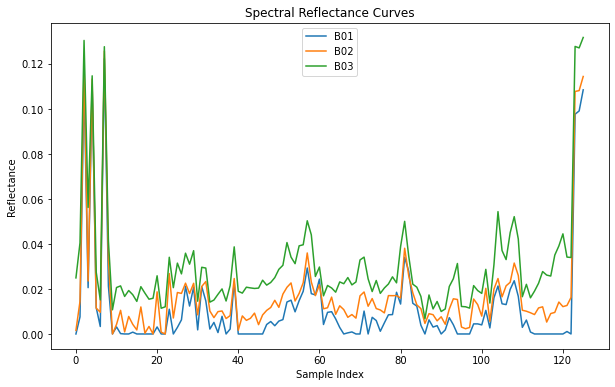

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your existing DataFrame
# Plotting the specified columns
plt.figure(figsize=(10, 6))
plt.plot(df['B01'], label='B01')
plt.plot(df['B02'], label='B02')
plt.plot(df['B03'], label='B03')

# Adding titles and labels
plt.title('Spectral Reflectance Curves')
plt.xlabel('Sample Index')
plt.ylabel('Reflectance')
plt.legend()

# Display the plot
plt.show()


In [3]:
#tsm_vantrepotte665 g/m^3
##df["tsm_vantrepotte665"] = (((260 * df["B04"]) / (1 - (df["B04"] / 0.142))) + 1.092)

#tsm_dogliotti665 g/m^3
#df["tsm_dogliotti665"] = (800 * df["B04"]) / (1 - df["B04"]/0.1728)

#tsm_zhang709 g/m^3(362507 * Rw705) ** 2.3222

df["tsm_zhang709"] = (362507 * df["B05"]) ** 2.3222

#tsm_binding754 g/m^3
df["tsm_binding754"] = (8.7774259 * df["B06"] - 0.00027) / 0.010526


df["Kutser"] =  df["B07"] -  df["B06"] + (df["B8A"]/2)   #Kutser, T., Paavel, B., Verpoorter, C., Ligi, M., Soomets, T., Toming, K., & Casal, G. (2016). Remote sensing of black lakes and using 810 nm reflectance peak for retrieving water quality parameters of optically complex waters. Remote Sensing, 8(6), 497.


df["Harma"] = df["B05"] -  df["B06"]    # Härmä, P., Vepsäläinen, J., Hannonen, T., Pyhälahti, T., Kämäri, J., Kallio, K., ... & Koponen, S. (2001). Detection of water quality using simulated satellite data and semi-empirical algorithms in Finland. Science of the Total Environment, 268(1-3), 107-121.


#equations used by MOBYGIS
df["TURMalkov2019a"] = df["B05"]   #Malkov, V. B., & Lowe, J. J. (2019). Applications of submersible fluorescence sensors for monitoring hydrocarbons in treated and untreated waters. Fluorescence in Industry, 135-171.
df["TURMalkov2019b"] = df["B06"]/df["B05"]   #Malkov, V. B., & Lowe, J. J. (2019). Applications of submersible fluorescence sensors for monitoring hydrocarbons in treated and untreated waters. Fluorescence in Industry, 135-171.
#df["TURKuhn2019"] = df["B04"]
df["TURPotes2018"] = df["B03"]/df["B01"] #Potes, M., Rodrigues, G., Penha, A. M., Novais, M. H., Costa, M. J., Salgado, R., & Morais, M. M. (2018). Use of Sentinel 2–MSI for water quality monitoring at Alqueva reservoir, Portugal. Proceedings of the International Association of Hydrological Sciences, 380, 73-79.

#df["TURHarma2001"] = (df["B01"] - df["B04"]) / (df["B03"] - df["B04"])
#df["TURRodrigues"] = df["B05"]/df["B02"]    #Rodrigues, G., Potes, M., Penha, A. M., Costa, M. J., & Morais, M. M. (2022). The use of Sentinel-3/OLCI for monitoring the water quality and optical water types in the largest Portuguese reservoir. Remote Sensing, 14(9), 2172.


#dataset["NDTI"] = ((dataset["B4"] - dataset["B3"])/(dataset["B4"] + dataset["B3"]))

#dataset["NDTII"] = (dataset["B5"] * (dataset["B5"] / dataset["B2"]))



In [4]:
df.columns

Index(['Date', 'Turbidity', 'ROI', 'SCL', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B8A', 'B11', 'B12', 'B01', 'tsm_zhang709', 'tsm_binding754',
       'Kutser', 'Harma', 'TURMalkov2019a', 'TURMalkov2019b', 'TURPotes2018'],
      dtype='object')

In [5]:
df

,Date,Turbidity,ROI,SCL,B02,B03,B04,B05,B06,B07,...,B11,B12,B01,tsm_zhang709,tsm_binding754,Kutser,Harma,TURMalkov2019a,TURMalkov2019b,TURPotes2018
0,2017-01-15,7.594000,1,1.0,0.001711,0.025000,0.009711,0.009611,0.000100,0.000111,...,0.001078,0.002767,0.000100,1.680466e+08,0.057737,0.000061,0.009511,0.009611,0.010405,250.000000
1,2017-01-25,6.170000,1,1.0,0.014556,0.040556,0.018911,0.023711,0.012578,0.011322,...,0.005878,0.005567,0.007689,1.368211e+09,10.462898,0.003783,0.011133,0.023711,0.530471,5.274548
2,2017-03-18,5.274000,1,1.0,0.119767,0.130422,0.114167,0.112822,0.104789,0.106433,...,0.103656,0.103133,0.111478,5.120512e+10,87.355851,0.053616,0.008033,0.112822,0.928799,1.169935
3,2017-04-05,6.576667,1,1.0,0.023600,0.056267,0.030789,0.036933,0.017511,0.016778,...,0.014456,0.013078,0.020667,3.829082e+09,14.576430,0.006189,0.019422,0.036933,0.474129,2.722553
4,2017-05-30,2.958000,1,1.0,0.113267,0.114711,0.105233,0.104478,0.100533,0.102111,...,0.104456,0.103878,0.110178,4.283749e+10,83.806855,0.051778,0.003945,0.104478,0.962241,1.041143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2022-01-19,6.566667,1,1.0,0.012756,0.034233,0.014156,0.014211,0.002856,0.002022,...,0.001322,0.002378,0.001189,4.167441e+08,2.355912,0.000655,0.011355,0.014211,0.200971,28.791421
122,2022-01-24,6.396667,1,1.0,0.016322,0.034056,0.015956,0.017289,0.007167,0.007333,...,0.005078,0.003744,0.000100,6.570429e+08,5.950771,0.002272,0.010122,0.017289,0.414541,340.560000
123,2022-01-29,5.510000,1,1.0,0.107778,0.127756,0.113267,0.112678,0.103889,0.103789,...,0.104400,0.103100,0.097678,5.105348e+10,86.605358,0.051439,0.008789,0.112678,0.921999,1.307930
124,2022-02-08,5.386667,1,1.0,0.108156,0.127111,0.111711,0.110356,0.101000,0.101022,...,0.102289,0.102233,0.099122,4.864355e+10,84.196277,0.050427,0.009356,0.110356,0.915220,1.282369


In [6]:
import numpy as np
columns_to_filter = ['tsm_zhang709', 'tsm_binding754','Kutser', 'Harma', 'TURMalkov2019a', 'TURMalkov2019b', 'TURPotes2018']
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=columns_to_filter)

# Compute the 1st and 99th percentiles for each column
percentiles = df[columns_to_filter].quantile([0.1, 0.9])

# Filter the DataFrame based on the percentiles
for column in columns_to_filter:
    lower_bound = percentiles.loc[0.1, column]
    upper_bound = percentiles.loc[0.9, column]
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [7]:
df

,Date,Turbidity,ROI,SCL,B02,B03,B04,B05,B06,B07,...,B11,B12,B01,tsm_zhang709,tsm_binding754,Kutser,Harma,TURMalkov2019a,TURMalkov2019b,TURPotes2018
5,2017-07-14,7.450000,1,1.0,0.011556,0.027511,0.008989,0.007089,0.000511,0.000733,...,0.004756,0.005589,0.011800,8.288443e+07,0.400462,0.000300,0.006578,0.007089,0.072084,2.331441
6,2017-08-18,2.828571,1,1.0,0.009756,0.015233,0.006389,0.004978,0.000522,0.001856,...,0.006433,0.005544,0.003422,3.647081e+07,0.409635,0.001434,0.004456,0.004978,0.104861,4.451490
10,2017-09-22,4.320000,1,1.0,0.004344,0.020733,0.010300,0.007944,0.000811,0.002756,...,0.011000,0.010733,0.003244,1.079731e+08,0.650626,0.003661,0.007133,0.007944,0.102090,6.391184
11,2017-09-27,3.908000,1,1.0,0.010600,0.021444,0.008444,0.005967,0.000144,0.001144,...,0.005700,0.005022,0.000256,5.555270e+07,0.094428,0.001094,0.005823,0.005967,0.024133,83.765625
13,2017-10-07,3.030000,1,1.0,0.007878,0.019389,0.006478,0.004267,0.000100,0.000100,...,0.004333,0.004344,0.000100,2.549854e+07,0.057737,0.000050,0.004167,0.004267,0.023436,193.890000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,2021-07-28,3.476667,1,1.0,0.021478,0.033133,0.015078,0.014022,0.004356,0.006456,...,0.004578,0.003867,0.013144,4.039863e+08,3.606733,0.003739,0.009666,0.014022,0.310655,2.520770
109,2021-08-27,4.893333,1,1.0,0.026111,0.042289,0.022078,0.022422,0.014056,0.016189,...,0.013444,0.010278,0.016800,1.201657e+09,11.695373,0.008666,0.008366,0.022422,0.626884,2.517202
111,2021-09-21,3.693333,1,1.0,0.010200,0.022144,0.014689,0.013267,0.006500,0.006200,...,0.009111,0.008333,0.006278,3.552609e+08,5.394572,0.002005,0.006767,0.013267,0.489937,3.527238
113,2021-10-06,3.786667,1,1.0,0.008722,0.019133,0.008778,0.007956,0.000300,0.001289,...,0.002711,0.001722,0.000100,1.083523e+08,0.224513,0.001039,0.007656,0.007956,0.037707,191.330000


In [8]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming `df` is your DataFrame

# Columns to compute correlation with 'Turbidity'
columns_of_interest = ['tsm_zhang709','tsm_binding754', 'Kutser', 'Harma', 'TURMalkov2019a', 'TURMalkov2019b','TURPotes2018']

# Dictionary to store results for each column of interest
results = {}

# Iterate through each parameter in the list
for parameter in columns_of_interest:
    # Prepare feature matrix X with only the current parameter and target vector y
    X = df[[parameter]]
    y = df['Turbidity']
    
    # Compute Pearson correlation
    pearson_corr = df[parameter].corr(df['Turbidity'])
    
    # Check if there are enough data points to perform regression
    if len(df) > 1:
        # Train linear regression model
        model = LinearRegression()
        model.fit(X, y)
        
        # Predict the target variable
        y_pred = model.predict(X)
        
        # Compute R-squared and RMSE
        r_squared = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
    else:
        r_squared = np.nan
        rmse = np.nan
    
    results[parameter] = {
        'row_count': len(df),
        'pearson_corr': pearson_corr,
        'r_squared': r_squared,
        'rmse': rmse
    }

# Print the results
for parameter, result in results.items():
    print(f"Results for parameter {parameter}:")
    print(f"  Row count: {result['row_count']}")
    print(f"  Pearson correlation: {result['pearson_corr']}")
    print(f"  R-squared: {result['r_squared']}")
    print(f"  RMSE: {result['rmse']}")
    print("\n")


Results for parameter tsm_zhang709:
  Row count: 61
  Pearson correlation: 0.18825095292403574
  R-squared: 0.03543842127680763
  RMSE: 1.2100001730055154


Results for parameter tsm_binding754:
  Row count: 61
  Pearson correlation: -0.0036161350510038183
  R-squared: 1.30764327074262e-05
  RMSE: 1.2320195901147577


Results for parameter Kutser:
  Row count: 61
  Pearson correlation: -0.0974456914409737
  R-squared: 0.009495662780409364
  RMSE: 1.226164233429289


Results for parameter Harma:
  Row count: 61
  Pearson correlation: 0.5526668780228603
  R-squared: 0.30544067806353514
  RMSE: 1.026774620339636


Results for parameter TURMalkov2019a:
  Row count: 61
  Pearson correlation: 0.19379628636347754
  R-squared: 0.03755700060827494
  RMSE: 1.208670610134366


Results for parameter TURMalkov2019b:
  Row count: 61
  Pearson correlation: -0.21692687111217457
  R-squared: 0.047057267410517856
  RMSE: 1.2026904272067156


Results for parameter TURPotes2018:
  Row count: 61
  Pearson 

In [9]:
df.columns

Index(['Date', 'Turbidity', 'ROI', 'SCL', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B8A', 'B11', 'B12', 'B01', 'tsm_zhang709', 'tsm_binding754',
       'Kutser', 'Harma', 'TURMalkov2019a', 'TURMalkov2019b', 'TURPotes2018'],
      dtype='object')

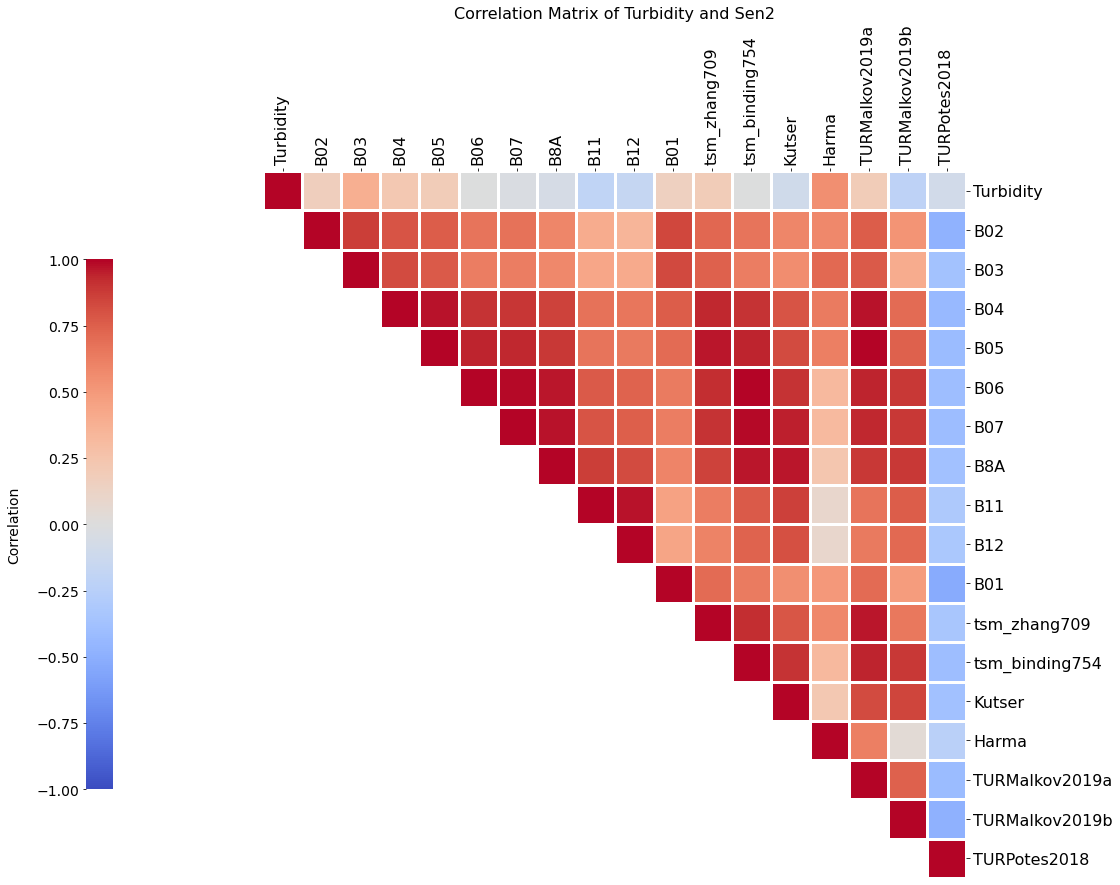

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


features = (['Turbidity','B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B8A', 'B11', 'B12', 'B01', 'tsm_zhang709', 'tsm_binding754',
       'Kutser', 'Harma', 'TURMalkov2019a', 'TURMalkov2019b', 'TURPotes2018'])
# Compute the correlation matrix
correlation_matrix = df[features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Add diagonal values manually
np.fill_diagonal(correlation_matrix.values, 1.0)

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(18, 13), facecolor='white')

heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=3, mask=~mask, cbar=True, vmin=-1, vmax=1, cbar_kws={"shrink": 0.75, "pad": 0.15, "location": "left"})
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation', fontsize=14, labelpad=15)

# Move x-axis ticks to the top and rotate
plt.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False, rotation=90, labelsize=12)
xticks_positions = np.arange(len(correlation_matrix.columns))
xticks_labels = correlation_matrix.columns
heatmap.set_xticks(xticks_positions + 0.5)
heatmap.set_xticklabels(xticks_labels, fontsize=16)

# Move y-axis ticks to the right and rotate
plt.tick_params(axis='y', right=True, labelright=True, left=False, labelleft=False, rotation=0, labelsize=12)
yticks_positions = np.arange(len(correlation_matrix.index))
yticks_labels = correlation_matrix.index
heatmap.set_yticks(yticks_positions + 0.5)
heatmap.set_yticklabels(yticks_labels, fontsize=16)
plt.title(fr'Correlation Matrix of Turbidity and Sen2', fontsize=16)

#plt.savefig(fr'D:\AliFarrokhi\Albufera models\{modelname}_corrmatrix.png', bbox_inches='tight', pad_inches=0.5, facecolor='w')

plt.show()


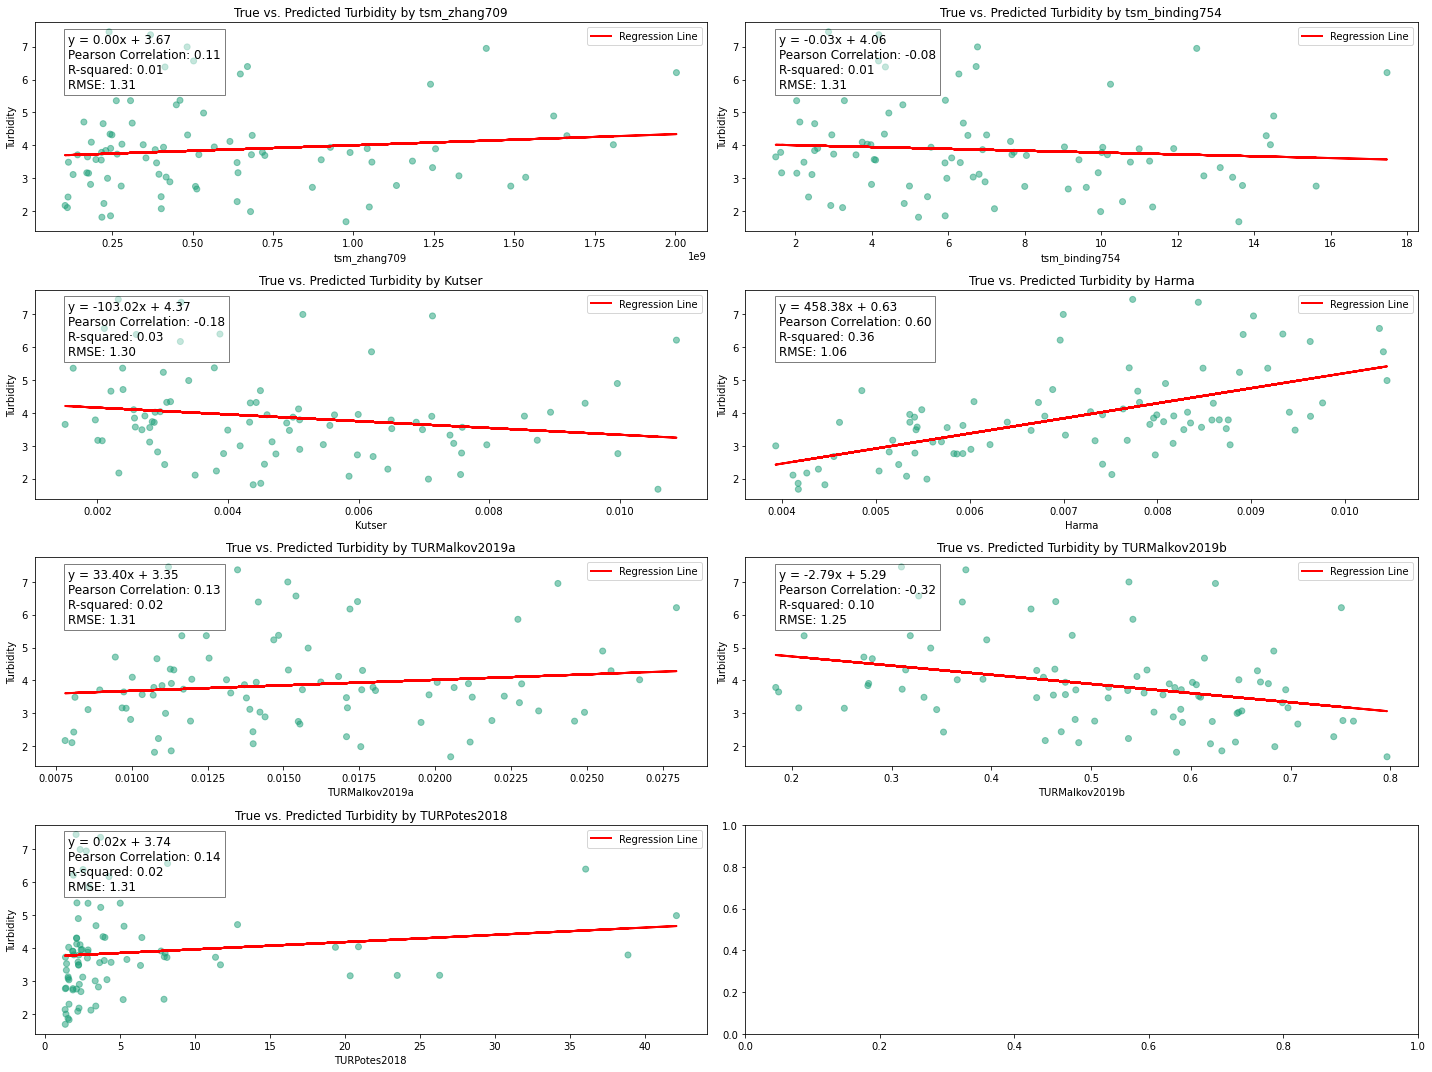

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming `df` is your DataFrame

# Columns to compute correlation with 'Turbidity'
columns_of_interest = ['tsm_zhang709', 'tsm_binding754', 'Kutser', 'Harma', 'TURMalkov2019a', 'TURMalkov2019b', 'TURPotes2018']

cmap = cm.get_cmap('Dark2')
fig, axs = plt.subplots(len(columns_of_interest) // 2 + len(columns_of_interest) % 2, 2, figsize=(20, 15))
fontseq = 12

# Create a function to plot each subplot with regression and colored points
def plot_with_regression(ax, x, y, x_label, y_label, title):
    scatter = ax.scatter(x, y, c=df['ROI'], cmap=cmap, alpha=0.5)
    
    # Perform linear regression
    regression_model = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
    predicted_y = regression_model.predict(np.array(x).reshape(-1, 1))
    
    # Calculate Pearson correlation coefficient
    pearson_corr, _ = pearsonr(x, y)
    
    # Calculate R-squared and RMSE
    r_squared = r2_score(y, predicted_y)
    rmse = np.sqrt(mean_squared_error(y, predicted_y))
    
    # Generate linear equation and metrics
    slope = regression_model.coef_[0]
    intercept = regression_model.intercept_
    metrics_text = (
        f'y = {slope:.2f}x + {intercept:.2f}\n'
        f'Pearson Correlation: {pearson_corr:.2f}\n'
        f'R-squared: {r_squared:.2f}\n'
        f'RMSE: {rmse:.2f}'
    )
    
    # Annotate the plot with linear equation and metrics
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=fontseq, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    
    # Plot regression line
    ax.plot(x, predicted_y, color='red', linestyle='-', linewidth=2, label='Regression Line')
    ax.legend()
    
    return scatter

# Plotting for each column of interest
for i, col in enumerate(columns_of_interest):
    row = i // 2
    col_pos = i % 2
    ax = axs[row, col_pos]
    
    scatter = plot_with_regression(ax, df[col], df['Turbidity'], col, 'Turbidity', f'True vs. Predicted Turbidity by {col}')

# Adjust layout and add a legend for the ROI colors
fig.tight_layout()
handles, labels = scatter.legend_elements(prop='colors', alpha=0.6)
# labels = [f'ROI {i+1}' for i in range(len(handles))]
# fig.legend(handles, labels, loc='upper right', title='ROI')

plt.savefig(r"D:\AliFarrokhi\Santa_Agueda\Finaldatasets\AverageoflakecloudfilterS2.png", bbox_inches='tight', pad_inches=0.5, facecolor='w')

plt.tight_layout()
plt.show()


In [10]:
df.columns

Index(['Date', 'Turbidity', 'ROI', 'SCL', 'B02', 'B03', 'B04', 'B05', 'B06',
       'B07', 'B8A', 'B11', 'B12', 'B01', 'tsm_zhang709', 'tsm_binding754',
       'Kutser', 'Harma', 'TURMalkov2019a', 'TURMalkov2019b', 'TURPotes2018'],
      dtype='object')

In [274]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from itertools import combinations

# Assuming 'df' is your DataFrame with the required columns
# List of features to try
features_list = ['B02', 'B03', 'B06','B07', 'B8A', 'B11', 'B12', 'Harma']

# Function to evaluate a model with given features
def evaluate_model(features):
    X = df[features]
    y = df['Turbidity']

    # Create bins for stratification
    y_binned = pd.qcut(y, q=13, labels=False)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40, stratify=y_binned)

    poly = PolynomialFeatures(degree=3)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r_squared_train = r2_score(y_train, y_train_pred)
    
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r_squared_test = r2_score(y_test, y_test_pred)
    
    sumrsquare = rmse_train + rmse_test
    difrsquare = abs(rmse_train - rmse_test)  # Absolute value to ensure non-negative difference
    
    return rmse_train, r_squared_train, rmse_test, r_squared_test, sumrsquare, difrsquare

# Store the results
results = []

# Try all combinations of features
for r in range(1, len(features_list) + 1):
    for subset in combinations(features_list, r):
        rmse_train, r_squared_train, rmse_test, r_squared_test, sumrsquare, difrsquare = evaluate_model(list(subset))
        results.append({
            'Features': subset,
            'Train RMSE': rmse_train,
            'Train R-squared': r_squared_train,
            'Test RMSE': rmse_test,
            'Test R-squared': r_squared_test,
            'SUM R-squared': sumrsquare,
            'DIF R-squared': difrsquare
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort the results first by SUM R-squared in descending order and then by DIF R-squared in ascending order
sorted_results_df = results_df.sort_values(by=['SUM R-squared', 'DIF R-squared'], ascending=[True, True])

# Get the best result
best_result = sorted_results_df.iloc[0]

print("Best Feature Subset:")
print(best_result)


Best Feature Subset:
Features           (B12, Harma)
Train RMSE             0.830938
Train R-squared        0.502094
Test RMSE              1.015043
Test R-squared         0.421243
SUM R-squared          1.845981
DIF R-squared          0.184105
Name: 35, dtype: object


Training RMSE: 0.732692936802265
Training R-squared: 0.6279477918417384
Test RMSE: 0.8415147282765553
Test R-squared: 0.6040634299666838


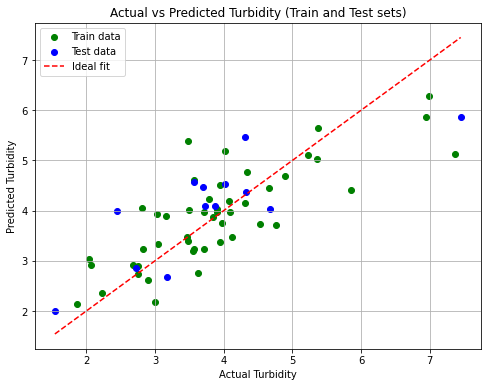

Equation: Turbidity = 5.15 + 210.05 * (Harma) + -409.33 * (B03) + -734.62 * (B07) + -250733.71 * (Harma^2) + 212920.37 * (Harma B03) + -141097.96 * (Harma B07) + -18953.62 * (B03^2) + 83428.63 * (B03 B07) + 1576.05 * (B07^2) + 18879214.09 * (Harma^3) + -8127520.02 * (Harma^2 B03) + 14121562.31 * (Harma^2 B07) + -4312506.05 * (Harma B03^2) + 15804698.26 * (Harma B03 B07) + -31936252.81 * (Harma B07^2) + 1143756.42 * (B03^3) + -7010730.10 * (B03^2 B07) + 13743816.47 * (B03 B07^2) + -7106288.42 * (B07^3) + 0.00


In [256]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
Features = ["Harma", "B03", "B07"]
X = df[Features]
y = df['Turbidity']

y_binned = pd.qcut(y, q=10, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 , stratify=y_binned)

# Create polynomial features
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict on training set
y_train_pred = model.predict(X_train_poly)
# Predict on test set
y_test_pred = model.predict(X_test_poly)

# Add predictions to the dataset
df.loc[X_train.index, 'Predicted_Turbidity_Train'] = y_train_pred
df.loc[X_test.index, 'Predicted_Turbidity_Test'] = y_test_pred

# Calculate error metrics for training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r_squared_train = r2_score(y_train, y_train_pred)

# Calculate error metrics for test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r_squared_test = r2_score(y_test, y_test_pred)

print("Training RMSE:", rmse_train)
print("Training R-squared:", r_squared_train)
print("Test RMSE:", rmse_test)
print("Test R-squared:", r_squared_test)

# Scatter plot of actual vs predicted Turbidity values for the training and test sets
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='green', label='Train data')
plt.scatter(y_test, y_test_pred, color='blue', label='Test data')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal fit')
plt.xlabel('Actual Turbidity')
plt.ylabel('Predicted Turbidity')
plt.title('Actual vs Predicted Turbidity (Train and Test sets)')
plt.legend()
plt.grid(True)
plt.savefig(r"D:\AliFarrokhi\Santa_Agueda\Finaldatasets\result.png", bbox_inches='tight', pad_inches=0.1, facecolor='w')
plt.show()

# Get coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Get feature names
feature_names = poly.get_feature_names_out(Features)

# Construct the equation
equation = f"Turbidity = {intercept:.2f}"
for i in range(1, len(coefficients)):
    equation += f" + {coefficients[i]:.2f} * ({feature_names[i]})"
equation += f" + {coefficients[0]:.2f}"

print("Equation:", equation)


In [95]:
df.describe()

,Turbidity,ROI,SCL,B02,B03,B04,B05,B06,B07,B8A,...,B01,tsm_zhang709,tsm_binding754,Kutser,Harma,TURMalkov2019a,TURMalkov2019b,TURPotes2018,Predicted_Turbidity_Train,Predicted_Turbidity_Test
count,61.000000,61.0,61.0,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,...,61.000000,6.100000e+01,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,58.000000,23.000000
mean,3.877736,1.0,1.0,0.013203,0.024437,0.012583,0.011191,0.004977,0.005697,0.004519,...,0.006675,3.227324e+08,4.124313,0.002980,0.006214,0.011191,0.367492,39.220536,3.929954,4.148534
std,1.242252,0.0,0.0,0.006868,0.008609,0.004863,0.005304,0.004387,0.004446,0.004202,...,0.006592,3.458825e+08,3.657824,0.002267,0.001889,0.005304,0.221021,68.979740,1.088257,1.631760
min,1.541250,1.0,1.0,0.000100,0.010078,0.005756,0.004000,0.000100,0.000100,0.000100,...,0.000100,2.194564e+07,0.057737,0.000050,0.003311,0.004000,0.022614,1.669091,1.561929,1.365781
25%,3.036000,1.0,1.0,0.008722,0.019367,0.008967,0.007389,0.001200,0.002111,0.000844,...,0.001000,9.125868e+07,0.975006,0.001089,0.004456,0.007389,0.167008,2.588433,3.262096,3.125000
50%,3.733333,1.0,1.0,0.011744,0.021900,0.011556,0.010189,0.003744,0.004489,0.003433,...,0.004578,1.924543e+08,3.096398,0.002528,0.006167,0.010189,0.388526,4.230450,3.750000,3.750000
75%,4.316667,1.0,1.0,0.018044,0.028789,0.015078,0.013911,0.008689,0.009100,0.008056,...,0.009989,3.965987e+08,7.219937,0.004384,0.007578,0.013911,0.540782,19.245884,4.440491,4.858876
max,7.450000,1.0,1.0,0.036067,0.050356,0.023289,0.024056,0.014700,0.016189,0.014344,...,0.029389,1.414886e+09,12.232392,0.008666,0.010200,0.024056,0.747849,226.220000,6.750000,8.250000
